In [308]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [309]:
fashion_mnist = keras.datasets.fashion_mnist

In [310]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

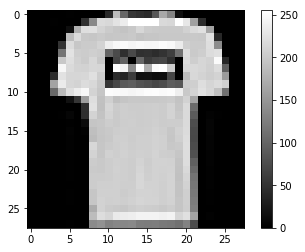

In [311]:
plt.imshow(train_images[1], cmap = 'gray')
plt.colorbar()

## Labels

In [312]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

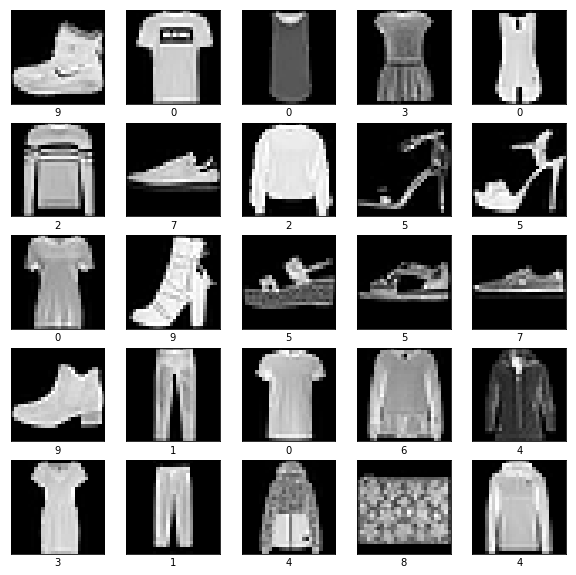

In [313]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

# INDICE: 
(con hipervinculo)

<ol>
    <li><a href="#ref1">Preparacion de la data</a></li>
    <li><a href="#ref2">Creacion del grafo</a></li>
    <li><a href="#ref3">Training</a></li>
</ol>  

<a id="ref1"></a>

# Preparacion de la data.

### Calculando el reshape de la data para que las Features sean un vector:

In [315]:
# Aplicacion de Reshape para luego filtrar la data.
yNumTrain  =  train_images.shape[0]
yNumTest   =  test_images.shape[0]
xImageSize =  train_images.shape[1]
yImageSize =  train_images.shape[2]

#Data con reshape:
trainReshapeX = np.reshape(train_images,(yNumTrain,xImageSize*yImageSize))
#print(trainReshapeX.shape)

testReshapeX = np.reshape(test_images,(yNumTest,xImageSize*yImageSize))
#print(testReshapeX.shape)

### Filtrando la data para obtener unicamente los valores Pantalon (1) , Vestido (3), Boota de ankle (9)

In [316]:
#Aplicando Filtrado a la data:
#choosenValues = np.array([1, #Trouser
#                          3, #Dress
#                          9])#Ankle boot

dictLabels = {1:'Trouser', 3:'Dress', 9:'Ankle boot'}

#print(train_labels[0:10])

#Este vector booleano es el que se aplicara a la data
getBoolFilterTrain = np.reshape(np.isin(train_labels,list(dictLabels.keys())),
                           (yNumTrain,1)) 

#Este vector booleano es el que se aplicara a la data
getBoolFilterTest = np.reshape(np.isin(test_labels,choosenValues),
                           (yNumTest,1)) 


#Filtrando las etiquetas de las imagenes de entrenamiento
yTrain = np.multiply(np.reshape(train_labels,(yNumTrain,1)),
                     getBoolFilterTrain)
yTrain = yTrain[~(yTrain==0).all(1)]

#OneHotEncoding - Y Training
oneHot_yTrain = np.reshape(np.eye(np.max(yTrain)+1)[yTrain.T],
                          (len(yTrain),np.max(yTrain)+1))[:,list(dictLabels.keys())]



#Filtrando las features de las etiquetas anteriormente seleccionadas:
xTrain = np.multiply(getBoolFilterTrain,trainReshapeX)
xTrain = xTrain[~(xTrain==0).all(1)]


#Filtrando las etiquetas de las imagenes de prueba:
yTest = np.multiply(np.reshape(test_labels,(yNumTest,1)),
                     getBoolFilterTest)
yTest = yTest[~(yTest==0).all(1)]

#OneHotEncoding - Y Training
oneHot_yTest = np.reshape(np.eye(np.max(yTest)+1)[yTest.T],
                          (len(yTest),np.max(yTest)+1))[:,list(dictLabels.keys())]

#Filtrando las features de las etiquetas anteriormente seleccionadas:
xTest = np.multiply(getBoolFilterTest,testReshapeX)
xTest = xTest[~(xTest==0).all(1)]

**Verificacion de que la data no se haya corrompido**

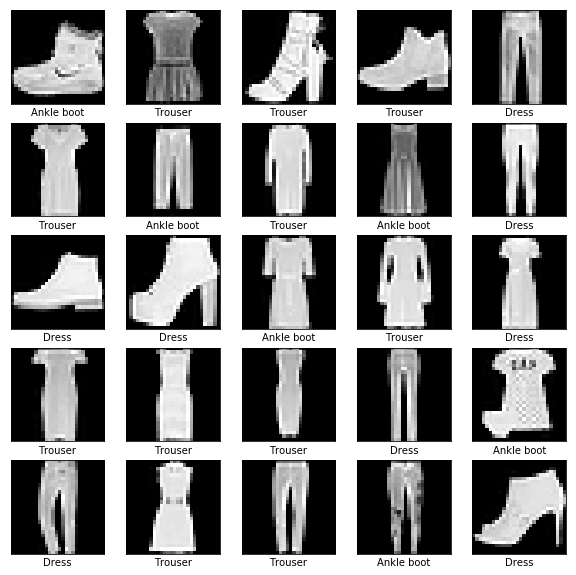

In [319]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(xTrain[i],(28,28)), cmap='gray')
    plt.xlabel(dictLabels[int(yTest[i])])
plt.show()

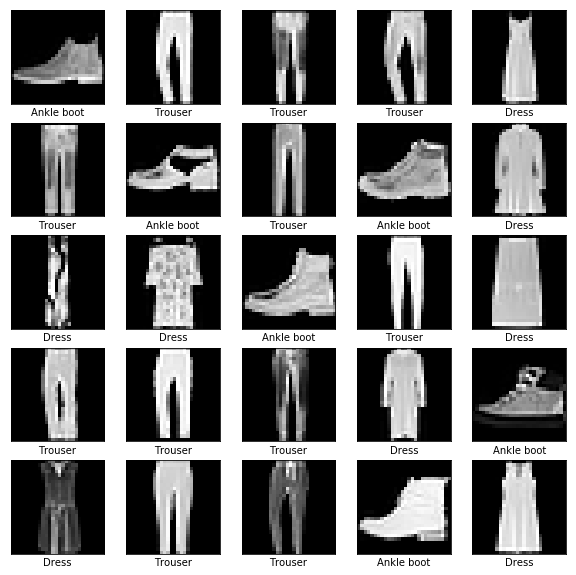

In [320]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(xTest[i],(28,28)), cmap='gray')
    plt.xlabel(dictLabels[int(yTest[i])])
plt.show()

### Separacion de la data escalada y no escalada

In [321]:
scaXTrain = np.divide(xTrain,255)
scaXTest  = np.divide(xTest,255)
#print(scaXTrain.shape)
#print(scaXTest.shape)
#18000/32
#scaXTest[0]

<a id="ref2"></a>
# Creacion del grafo:

In [322]:
#Parametros externos:
miniBatch = 32
numLabels = len(dictLabels)
numFeatures = xImageSize*yImageSize

#Nombramiento del grafo:
logicRegresion = tf.Graph()

#construccion:
with logicRegresion.as_default():
    #Creacion de la primera agrupacion: Se incluira aqui variables, placeholders, constantes, etc.
    with tf.name_scope("DataToUse") as scope:
        
        #Utilizacion de padding para crear la matriz de unos:
        padding = tf.constant([[0,0],[1,0]])
        
        
        #Learning rate as placeholder
        learningRate = tf.placeholder(dtype=tf.float32,name='LearningRate')
    
            
        #Features, en este caso seran matrices de (32x784)
        preX = tf.placeholder(dtype=tf.float32,shape=[miniBatch,numFeatures],
                              name="FeatureVect") #vector de 32x784
        
        X = tf.pad(tensor=preX,paddings=padding, mode='CONSTANT',
                     constant_values=1.0000) #vector de 32x785
        
        #Creacion de las etiquetas:
        Y = tf.placeholder(dtype=tf.float32,shape=[miniBatch,numLabels],
                              name="ClothesTipy") #Vector de 32x3
        
        
        #Creacion de la matriz de parametros a entrenar, debido a que el bias va incluido, se agrega una  
        #caracteristica mas.
        weights = tf.Variable(tf.random_normal([numFeatures+1,numLabels],
                                               mean=0,
                                               stddev=0.01,
                                               name="Weights")) #Matriz de 785x3
        
        # Initialize our weights and biases variables.
        varInit = tf.global_variables_initializer()

    with tf.name_scope("Hipothesis") as scope:
        #Matriz de 32x3, distribucion de probabilidad ya que se utiliza 
        #HypothesisPolinomial  = tf.matmul(X,weights)
        Hypothesis = tf.nn.softmax(tf.matmul(X,weights),axis=1,name="softmaxActiva")
    
    
    with tf.name_scope("CostFunction") as scope:
        #Defining our cost function - Squared Mean Error
        ySoftMax = tf.nn.softmax(Y,axis=1,name="SoftMaxY")
        crossEntropyLoss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = ySoftMax, logits = tf.matmul(X,weights))
        finalCrossEntropy = tf.reduce_mean(crossEntropyLoss,axis=0)
        
        #Defining our Gradient Descent
        gradientDescent = tf.train.GradientDescentOptimizer(learningRate).minimize(finalCrossEntropy)
    
    with tf.name_scope("TrainingVisualization") as scope:
        predicttionBool = tf.equal(tf.argmax(Hypothesis,1),tf.argmax(Y,1)) # me retorna un vector bool de 1xN
        accuracyCalc = tf.reduce_mean(tf.cast(predicttionBool, "float"))

# Entrenamiento

In [323]:
xPreTrain = scaXTrain[:32]
yPreTrain = oneHot_yTrain[:32]

def trainingModel(features, labels, miniBatch, lr, epochs):
    batch = int(labels.shape[0]/miniBatch)
    tf.reset_default_graph()
    with tf.Session(graph=logicRegresion) as session:
        session.run(varInit)
        for j in range(epochs):
            #For aplicando el miniBatch:
            for i in range(batch):
                #print("Rango", (i*miniBatch,(i+1)*miniBatch))
                session.run([gradientDescent],feed_dict={learningRate:lr, preX:features[i*miniBatch:(i+1)*miniBatch], 
                                                         Y:labels[i*miniBatch:(i+1)*miniBatch]})
                error,accuracy, pesos = session.run([finalCrossEntropy,accuracyCalc, weights],
                                             feed_dict={learningRate:lr, preX:features[i*miniBatch:(i+1)*miniBatch], 
                                                        Y:labels[i*miniBatch:(i+1)*miniBatch]})
            if j%1==0:
                print('Error: ',str(error),' accuracy: ', str(accuracy))
        return pesos

In [335]:
trainedW = trainingModel(features=scaXTrain,labels=oneHot_yTrain,miniBatch=32,lr=0.003,epochs=2)

Error:  0.9963552  accuracy:  0.96875
Error:  0.9939067  accuracy:  0.96875


In [336]:
testImage = tf.Graph()
with testImage.as_default(): 
    preTestX = tf.placeholder(dtype=tf.float32, shape=(1,xImageSize*yImageSize))
    padding = tf.constant([[0,0],[1,0]])
    TestXt = tf.pad(tensor=preTestX,paddings=padding, mode='CONSTANT', constant_values=1.0000)
    trainedValues = tf.placeholder(dtype=tf.float32,shape=(785,3))
    #Vector de 1x3 con la mejor probabilidad
    Y_hat = tf.nn.softmax(tf.matmul(TestXt,trainedValues),axis=1,name="softmaxActiva")

In [341]:
def testFunction(X,W,it):
    with tf.Session(graph=testImage) as session:
        prediction = session.run(Y_hat, feed_dict={preTestX:X,trainedValues:W})
    
    #print(len(prediction[0]))
    #print(np.argmax(prediction[0]))
    finalLabel = dictLabels[list(dictLabels.keys())[np.argmax(prediction[0])]]
    #print(dictLabels.keys[np.argmax(prediction[0])])
    #print(labelsAble)
    
    plt.figure(figsize=(10,10))
    print(it)
    plt.subplot(5,5,it+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.reshape(X,(28,28)), cmap='gray')
    plt.xlabel(finalLabel)
    plt.show()

0


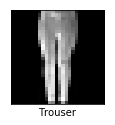

1


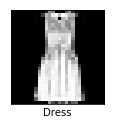

2


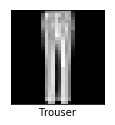

3


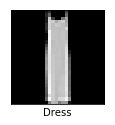

4


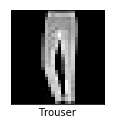

5


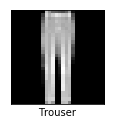

6


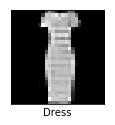

7


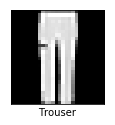

8


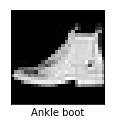

9


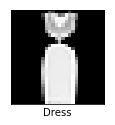

10


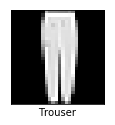

11


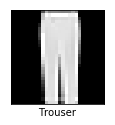

12


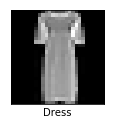

13


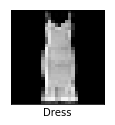

14


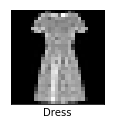

15


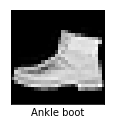

16


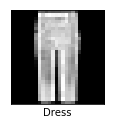

17


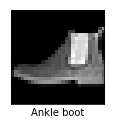

18


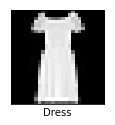

19


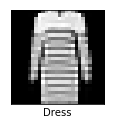

20


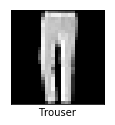

21


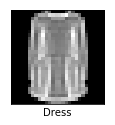

22


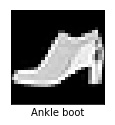

23


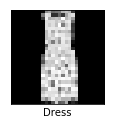

24


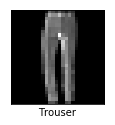

In [342]:
#len(scaXTest)
#lol = scaXTest[[0]]
#print(np.asanyarray(trainedW))
#testFunction(lol,np.asanyarray(trainedW))
#scaXTest[[0]].shape
np.random.randint(0,2999)
for i in range(25):
    testFunction(X=scaXTest[[np.random.randint(0,2999)]],W=trainedW,it=i)


# Resolucion de dudas

Nota: Se les envia el feed_dict SOLO A LOS PLACEHOLDERS. Evaluacion perezosa: Primero crear la estructura y luego ejecutarla. Modelo parametrico -> Parametros entrenables (esto es tf.Variable), esta es la pieza movil.

En ejecucion, tensor flows ejecuta todas las dependencias del grafo que se ejecuta.

My own questions:

* Para filtrar podemos usar vectores de booleanos. Conceptualmente se entrenan cuatro modelos de regresion logistica de manera paralelo. Al final en el dataSet
* Cada pixel de la imagen es una caracteristica!!!!!
* Reshape: 
* Minbatch -> sets de 32 ejemplos 
* Normalizacion <- Introduction to Feature Engineering. (Hace que el gradient descent tenga una curva mas facil de descender)



**NOTA EN EL MINIBATCH VAMOS A ENTRENAR SI O SI, SETS DE 32 INPUTS**

Si el dataset tuviera 3200 imagenes, por cada epoch

In [73]:
print(yTrain[:10].T.shape)

(1, 10)


In [72]:
print(np.transpose(yTrain[:10]).shape)

(1, 10)
